<a href="https://colab.research.google.com/github/mike56k/system-analysis/blob/main/Character_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import pandas as pd

In [70]:
df = pd.read_csv("./drive/MyDrive/diplom-datasets/phishing_site_urls.csv")
df.replace({'good':0, 'bad':1}, inplace=True)
ok

In [71]:
df.drop_duplicates(subset=["URL"], inplace=True)

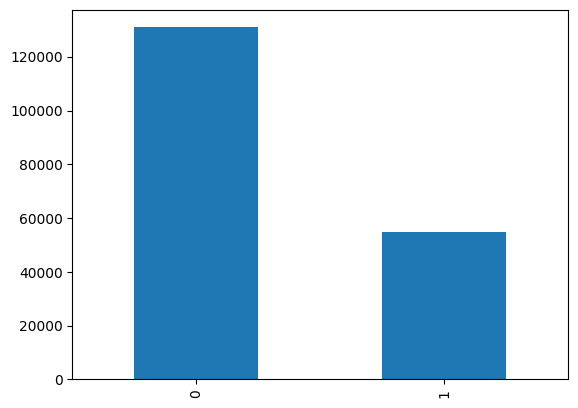

In [72]:
df = df[df.apply(lambda x: False if len(x.URL) < 50 else True, axis=1)] # experiment with URL len

import matplotlib.pyplot as plt
counts = df['Label'].value_counts()
counts.plot(kind='bar')
plt.show()

In [73]:
df = df.sample(frac=1).reset_index(drop=True)
counts = df['Label'].value_counts()
minority_class = counts.idxmin()
majority_class = df[df['Label'] != minority_class]
majority_class_sampled = majority_class.sample(n=counts[minority_class])
balanced_df = pd.concat([majority_class_sampled, df[df['Label'] == minority_class]])
df = balanced_df.sample(frac=1).reset_index(drop=True)

In [74]:
from keras.preprocessing.text import Tokenizer

urls = [s for s in df.URL]
tk = Tokenizer(num_words=None, lower=True, char_level=True, oov_token='UNK')
tk.fit_on_texts(urls)

In [75]:
alphabet = "abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}’"
char_dict = {}
for i, char in enumerate(alphabet):
    char_dict[char] = i + 1

tk.word_index = char_dict.copy()
tk.word_index[tk.oov_token] = max(char_dict.values()) + 1

In [76]:
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences

X_train, X_test, y_train, y_test = train_test_split(df.URL, df.Label, test_size=0.2)

train_sequences = tk.texts_to_sequences(X_train)
test_texts = tk.texts_to_sequences(X_test)

MAX_LEN = 180
train_data = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post')
test_data = pad_sequences(test_texts, maxlen=MAX_LEN, padding='post')

In [77]:
import tensorflow as tf

train_classes = tf.convert_to_tensor(y_train)
test_classes = tf.convert_to_tensor(y_test)

### Создание модели

In [78]:
import numpy as np

def get_embedding_weights_for_one_hot_encoding(vocab_size):
  embedding_weights = []
  embedding_weights.append(np.zeros(vocab_size)) # first row is pad

  for char, i in tk.word_index.items():
      onehot = np.zeros(vocab_size)
      onehot[i-1] = 1
      embedding_weights.append(onehot)
  embedding_weights = np.array(embedding_weights)
  return embedding_weights

In [79]:
import keras
from keras.layers import Input, Embedding, Activation, Flatten, Dense
from keras.layers import Conv1D, MaxPooling1D, Dropout
from keras.models import Model

vocab_size = len(tk.word_index)
input_size = MAX_LEN
embedding_size = 70
conv_layers = [[256, 7, 3],
               [256, 7, 3],
               [256, 3, -1],
               [256, 3, -1],
               [256, 3, -1],
               [256, 3, 3]]

fully_connected_layers = [1024, 1024]
num_of_classes = 1
dropout_p = 0.5
optimizer = 'adam'
loss = 'binary_crossentropy'

def cnn_model():
  inputs = Input(shape=(input_size,), name='input', dtype='int32')
  embedding = Embedding(input_dim=vocab_size+1, 
                        output_dim=embedding_size,
                        input_length=input_size,
                        weights=[get_embedding_weights_for_one_hot_encoding(vocab_size)])
  x = embedding(inputs)
  for filter_num, filter_size, pooling_size in conv_layers:
      x = Conv1D(filters=filter_num, kernel_size=filter_size)(x) 
      x = Activation('relu')(x)
      if pooling_size != -1:
          x = MaxPooling1D(pool_size=pooling_size)(x)
  x = Flatten()(x)
  for dense_size in fully_connected_layers:
      x = Dense(dense_size, activation='relu')(x)
      x = Dropout(dropout_p)(x)
  predictions = Dense(num_of_classes, activation='sigmoid')(x)
  model = Model(inputs=inputs, outputs=predictions)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), 
                                                                          keras.metrics.Precision(), 
                                                                          keras.metrics.Recall(),
                                                                          tf.keras.metrics.FalsePositives(),
                                                                          tf.keras.metrics.FalseNegatives()])
  return model

model = cnn_model()

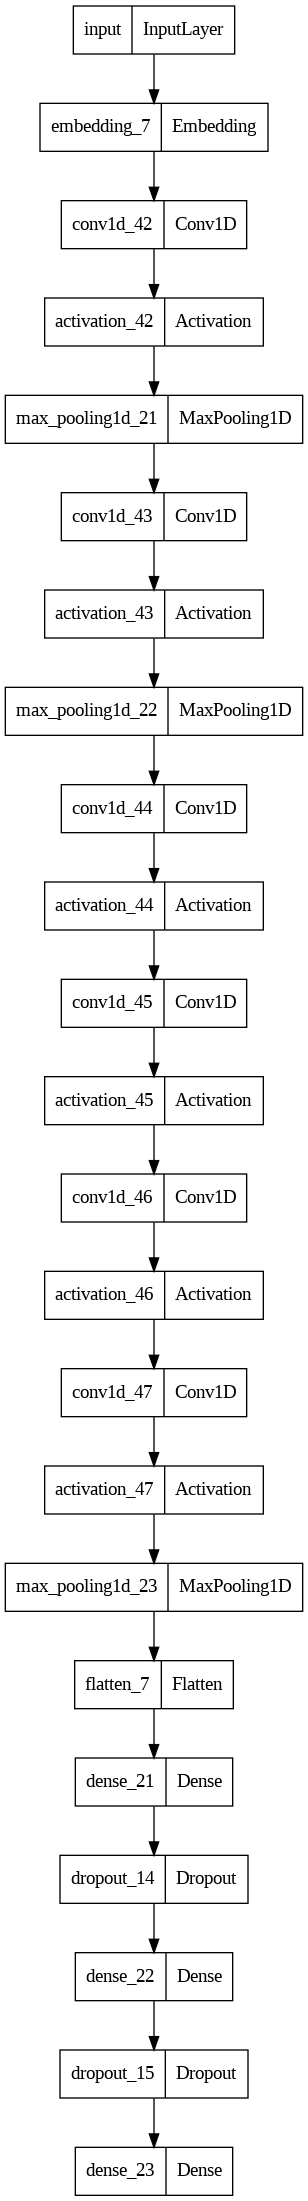

In [80]:
from keras.utils import plot_model

plot_model(model)

### Обучение

In [81]:
with tf.device('/device:GPU:0'):
  history = model.fit(
    train_data,
    train_classes,
    batch_size=1024,
    epochs=3,
    validation_data=(test_data, test_classes),
  )

Epoch 1/3
86/86 [==============================] - 1132s 13s/step - loss: 0.3361 - binary_accuracy: 0.8380 - precision_7: 0.8662 - recall_7: 0.7991 - false_positives_7: 5393.0000 - false_negatives_7: 8774.0000 - val_loss: 0.1700 - val_binary_accuracy: 0.9392 - val_precision_7: 0.9787 - val_recall_7: 0.8985 - val_false_positives_7: 215.0000 - val_false_negatives_7: 1114.0000
Epoch 2/3
86/86 [==============================] - 1138s 13s/step - loss: 0.0933 - binary_accuracy: 0.9685 - precision_7: 0.9703 - recall_7: 0.9665 - false_positives_7: 1293.0000 - false_negatives_7: 1464.0000 - val_loss: 0.0653 - val_binary_accuracy: 0.9789 - val_precision_7: 0.9776 - val_recall_7: 0.9804 - val_false_positives_7: 247.0000 - val_false_negatives_7: 215.0000
Epoch 3/3
86/86 [==============================] - 1110s 13s/step - loss: 0.0468 - binary_accuracy: 0.9856 - precision_7: 0.9873 - recall_7: 0.9839 - false_positives_7: 551.0000 - false_negatives_7: 705.0000 - val_loss: 0.0510 - val_binary_accurac

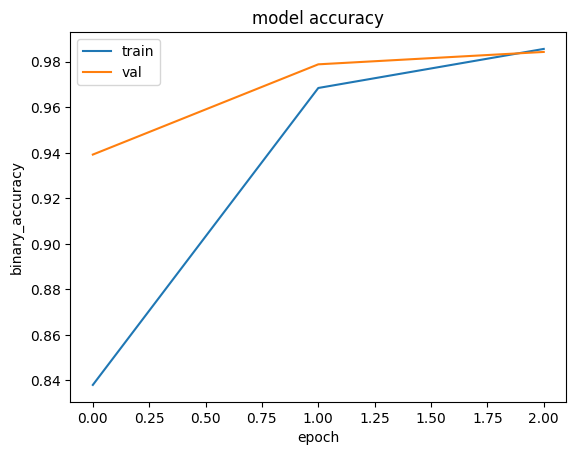

In [82]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

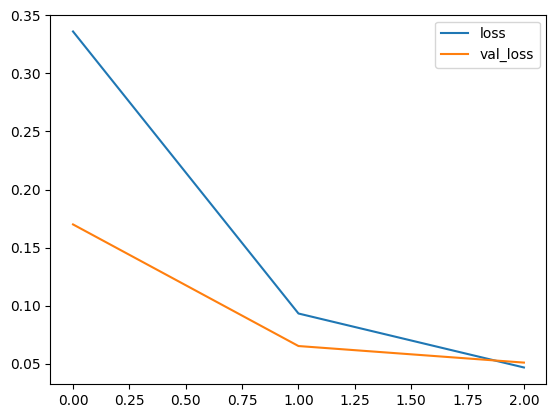

In [83]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Тестирование на реальных данных

In [88]:
test_texts = tk.texts_to_sequences(["stackoverflow.com/questions/18039057/python-pandas-error-tokenizing-data",  # не фишинг
                                    "research.misis.ru/sciencedays",                                             # не фишинг
                                    "raiffeisen-portal.siterubix.com/app/ebnking/upp/",                          # фишинг
                                    "business-confirm-appeal-4bbe4.firebaseapp.com",                             # фишинг
                                    "www.kaggle.com/code/asterfung/phishing-website-detection-random-forest-96", # не фишинг
                                    "docs.google.com/document"])                                                 # не фишинг

test_data = pad_sequences(test_texts, maxlen=MAX_LEN, padding='post')
model.predict(test_data)

1/1 [==============================] - 0s 320ms/step


array([[0.00112732],
       [0.26707447],
       [0.9988604 ],
       [0.974833  ],
       [0.0031253 ],
       [0.38391975]], dtype=float32)

### Сохранение

In [89]:
model.save("character_cnn.h5")

In [91]:
%pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [92]:
import tensorflowjs as tfjs

def save_model_to_tfjs(model):
  tfjs.converters.save_keras_model(model, "character_cnn_tfjs")

save_model_to_tfjs(model)

NotFoundError: ignored

In [ ]:
!zip -r tensorflow_js_model.zip tensorflow_js_model/ 